In [115]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from torchlake.common.controller.recorder import TrainRecorder
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_normal
from torchlake.image_generation.controllers.trainer_acgan import ACGANTrainer
from torchlake.image_generation.controllers.predictor_cgan import CGANPredictor
from torchlake.image_generation.models.dcgan import DCGANGenerator
from torchlake.image_generation.models.acgan import (
    ACGANDiscriminatorLoss,
    ACGANGeneratorLoss,
    ACGANDiscriminator,
)

# Setting

In [116]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

In [117]:
artifact_path = Path("../../artifacts/acgan")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/fashionMnist")

In [118]:
# DEVICE = torch.device("cpu")
DEVICE = torch.device("cuda:0")

# Data

In [119]:
NUM_CLASS = 10 # len(train_data.classes)

In [120]:
preprocess = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        lambda x: 2 * x - 1,
    ]
)

In [121]:
train_data = torchvision.datasets.FashionMNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

test_data = torchvision.datasets.FashionMNIST(
    root=data_path.as_posix(),
    train=False,
    transform=preprocess,
    download=True,
)

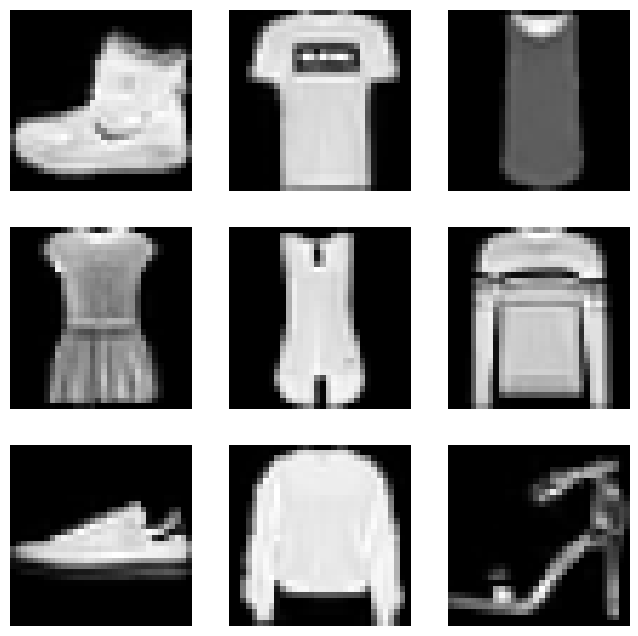

In [122]:
# 資料集繪圖
plot_grids(
    [*img_tensor_to_np(torch.stack([train_data[i][0] for i in range(9)]))],
    num_row=3,
    num_col=3,
    cmap="gray",
)

In [123]:
import torch.nn.functional as F

def cond_collate_fn(batch):
    x, y = [], []
    for img, label in batch:
        x.append(img)
        y.append(label)
        
    # B, C, H, W # B*C, H, W
    y = torch.LongTensor(y)
    return torch.stack(x), y, F.one_hot(y, NUM_CLASS).float()

In [124]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=cond_collate_fn,
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=cond_collate_fn,
)

In [125]:
for x, y, c in train_loader:
    print(x.shape, y.shape, c.shape)
    break

torch.Size([128, 1, 32, 32]) torch.Size([128]) torch.Size([128, 10])


# model

In [126]:
LATENT_DIM = 128
HIDDEN_DIM = 1024

In [127]:
generator = DCGANGenerator(
    LATENT_DIM + NUM_CLASS,
    output_size=1,
    hidden_dim=HIDDEN_DIM,
    init_shape=(2, 2),
).to(DEVICE)
discriminator = ACGANDiscriminator(
    1,
    NUM_CLASS,
    hidden_dim=HIDDEN_DIM // 16,
    image_shape=(IMAGE_SIZE, IMAGE_SIZE),
).to(DEVICE)

In [128]:
torchinfo.summary(generator)

Layer (type:depth-idx)                   Param #
DCGANGenerator                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       569,344
│    └─Unflatten: 2-2                    --
│    └─BatchNorm2d: 2-3                  2,048
├─Sequential: 1-2                        --
│    └─ConvBNReLU: 2-4                   --
│    │    └─ConvTranspose2d: 3-1         8,388,608
│    │    └─BatchNorm2d: 3-2             1,024
│    │    └─ReLU: 3-3                    --
│    └─ConvBNReLU: 2-5                   --
│    │    └─ConvTranspose2d: 3-4         2,097,152
│    │    └─BatchNorm2d: 3-5             512
│    │    └─ReLU: 3-6                    --
│    └─ConvBNReLU: 2-6                   --
│    │    └─ConvTranspose2d: 3-7         524,288
│    │    └─BatchNorm2d: 3-8             256
│    │    └─ReLU: 3-9                    --
│    └─ConvBNReLU: 2-7                   --
│    │    └─ConvTranspose2d: 3-10        131,072
│    │    └─BatchNorm2d: 3-11     

In [129]:
torchinfo.summary(discriminator)

Layer (type:depth-idx)                   Param #
ACGANDiscriminator                       --
├─Sequential: 1-1                        --
│    └─Conv2dNormActivation: 2-1         --
│    │    └─Conv2d: 3-1                  640
│    │    └─LeakyReLU: 3-2               --
├─Sequential: 1-2                        --
│    └─Conv2dNormActivation: 2-2         --
│    │    └─Conv2d: 3-3                  73,728
│    │    └─BatchNorm2d: 3-4             256
│    │    └─LeakyReLU: 3-5               --
│    └─Conv2dNormActivation: 2-3         --
│    │    └─Conv2d: 3-6                  294,912
│    │    └─BatchNorm2d: 3-7             512
│    │    └─LeakyReLU: 3-8               --
│    └─Conv2dNormActivation: 2-4         --
│    │    └─Conv2d: 3-9                  1,179,648
│    │    └─BatchNorm2d: 3-10            1,024
│    │    └─LeakyReLU: 3-11              --
│    └─Conv2dNormActivation: 2-5         --
│    │    └─Conv2d: 3-12                 4,718,592
│    │    └─BatchNorm2d: 3-13            2

# train

In [130]:
from typing import Generator

def noise_generator(batch_size: int, device: torch.device) -> Generator[torch.Tensor, None, None]:
    while True:
        yield generate_normal(batch_size, LATENT_DIM).to(device)

In [131]:
EPOCH = 10

In [132]:
trainer = ACGANTrainer(EPOCH, DEVICE)

In [133]:
recorder = TrainRecorder(total_epoch=EPOCH, num_loss=2, loss_names=["discriminator", "generator"])
recorder.increment_data_size(len(train_data))

In [134]:
LR = 5e-5
BETA = (0.5, 0.999)

In [135]:
criterion_g = ACGANGeneratorLoss()
criterion_d = ACGANDiscriminatorLoss()
optim_g = torch.optim.Adam(generator.parameters(), lr=LR, betas=BETA)
optim_d = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)

In [136]:
training_losses = trainer.run(
    train_loader,
    noise_generator,
    generator,
    discriminator,
    optim_g,
    optim_d,
    criterion_g,
    criterion_d,
    recorder=recorder,
)

Enable AMP: False


100%|██████████| 468/468 [00:40<00:00, 11.50it/s]


------------------------------------
Epoch 1
------------------------------------
discriminator: 1.3746e-02 (0.00%)
generator: 1.1026e-02 (0.00%)


100%|██████████| 468/468 [00:40<00:00, 11.60it/s]


------------------------------------
Epoch 2
------------------------------------
discriminator: 2.0885e-02 (52.00%)
generator: 2.4844e-02 (125.00%)


100%|██████████| 468/468 [00:40<00:00, 11.64it/s]


------------------------------------
Epoch 3
------------------------------------
discriminator: 2.8652e-02 (37.00%)
generator: 3.8234e-02 (54.00%)


100%|██████████| 468/468 [00:40<00:00, 11.55it/s]


------------------------------------
Epoch 4
------------------------------------
discriminator: 3.6229e-02 (26.00%)
generator: 5.2450e-02 (37.00%)


100%|██████████| 468/468 [00:40<00:00, 11.51it/s]


------------------------------------
Epoch 5
------------------------------------
discriminator: 4.3878e-02 (21.00%)
generator: 6.6148e-02 (26.00%)


100%|██████████| 468/468 [00:39<00:00, 11.93it/s]


------------------------------------
Epoch 6
------------------------------------
discriminator: 5.1063e-02 (16.00%)
generator: 8.0260e-02 (21.00%)


100%|██████████| 468/468 [00:35<00:00, 13.20it/s]


------------------------------------
Epoch 7
------------------------------------
discriminator: 5.7202e-02 (12.00%)
generator: 9.6448e-02 (20.00%)


100%|██████████| 468/468 [00:40<00:00, 11.67it/s]


------------------------------------
Epoch 8
------------------------------------
discriminator: 6.2829e-02 (10.00%)
generator: 1.1450e-01 (19.00%)


100%|██████████| 468/468 [00:40<00:00, 11.59it/s]


------------------------------------
Epoch 9
------------------------------------
discriminator: 6.7360e-02 (7.00%)
generator: 1.3478e-01 (18.00%)


100%|██████████| 468/468 [00:40<00:00, 11.57it/s]

------------------------------------
Epoch 10
------------------------------------
discriminator: 7.1992e-02 (7.00%)
generator: 1.5598e-01 (16.00%)


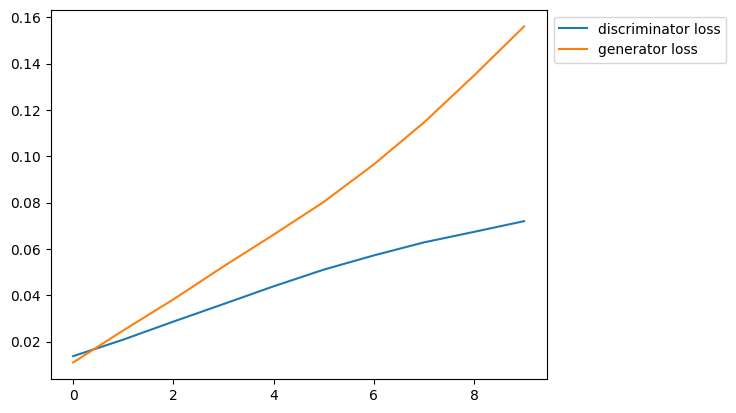

In [137]:
plt.plot(training_losses[0], label="discriminator loss")
plt.plot(training_losses[1], label="generator loss")
plt.legend(bbox_to_anchor=(1, 1))

# evaluation

In [138]:
TEST_BATCH_SIZE = 16

In [139]:
for i, c in enumerate(train_data.classes): print(i, ":", c)

0 : T-shirt/top
1 : Trouser
2 : Pullover
3 : Dress
4 : Coat
5 : Sandal
6 : Shirt
7 : Sneaker
8 : Bag
9 : Ankle boot


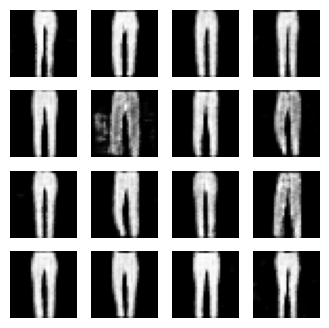

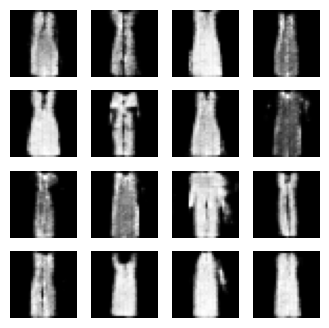

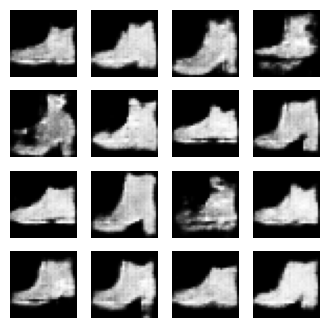

In [147]:
predictor = CGANPredictor(DEVICE)

noise = noise_generator(TEST_BATCH_SIZE, DEVICE)

# Trouser
gen_img = predictor.run(noise, F.one_hot(torch.full((TEST_BATCH_SIZE,), 1), NUM_CLASS).to(DEVICE), generator)

plot_grids(
    img_tensor_to_np(gen_img),
    num_row=4,
    num_col=4,
    is_gray_scale=True,
    figsize=(4,4),
)

# Dress
gen_img = predictor.run(noise, F.one_hot(torch.full((TEST_BATCH_SIZE,), 3), NUM_CLASS).to(DEVICE), generator)
    
plot_grids(
    img_tensor_to_np(gen_img),
    num_row=4,
    num_col=4,
    is_gray_scale=True,
    figsize=(4,4),
)

# Ankle boot
gen_img = predictor.run(noise, F.one_hot(torch.full((TEST_BATCH_SIZE,), 9), NUM_CLASS).to(DEVICE), generator)

plot_grids(
    img_tensor_to_np(gen_img),
    num_row=4,
    num_col=4,
    is_gray_scale=True,
    figsize=(4,4),
)

In [141]:
# 區別是否為真實圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, _, _ in tqdm(train_loader):
        img = img.to(DEVICE)
        hits += discriminator(img)[:, 0].sigmoid().gt(0.5).sum().item()

    print(hits / len(train_data))

100%|██████████| 468/468 [00:23<00:00, 20.11it/s]

0.2421


In [142]:
# 區別是否為合成圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for _, _, c in tqdm(train_loader):
        c = c.to(DEVICE)
        noise = torch.cat((generate_normal(BATCH_SIZE, LATENT_DIM).to(DEVICE), c), 1)
        gen_img = generator(noise)
        
        c = c[:, :, None, None].expand(BATCH_SIZE, NUM_CLASS, IMAGE_SIZE, IMAGE_SIZE)
        hits += discriminator(gen_img)[:, 0].sigmoid().gt(0.5).sum().item()
    print(hits / len(train_data))

100%|██████████| 468/468 [00:20<00:00, 22.42it/s]

0.060566666666666664


In [143]:
from torchlake.common.controller.weight_manager import WeightManager

weight_manager = WeightManager(artifact_path.joinpath('acgan.pth').as_posix())

In [144]:
generator_path = weight_manager.get_filename()
generator_path

WindowsPath('../../artifacts/acgan/acgan.pth')

In [145]:
weight_manager.save_weight(generator.state_dict(), generator_path)

Save weight to ..\..\artifacts\acgan\acgan.pth, model size is 44.71MiB


In [146]:
weight_manager.load_weight(generator_path, generator)